In [ ]:
library(Signac)
library(Seurat)
library(GenomicRanges)
library(future)

plan("multisession", workers = 24)
options(future.globals.maxSize = 50 * 1024 ^ 3) # for 50 Gb RAM

In [ ]:
#import preprocessed signac objects - dblfiltered, strict qc done, reference anotation added

In [ ]:
ataclist <- c("E13.5_ATAC", 
              "E16.5_ATAC", 
              "E18.5_ATAC_geni", "E18.5_ATAC_GMI", 
              "PD0_ATAC_GMI1", "PD0_ATAC_GMI2", 
              "PD2_ATAC_geni1", "PD2_ATAC_geni2", 
              "PD4_ATAC_geni1", "PD4_ATAC_geni2")

In [ ]:
ataclist

In [ ]:
for (i in ataclist) {
    assign(i, readRDS(paste0("/data/User/revolvefire/projects/1.ATAC_230519/240109_ATAC_reintegrate/RDS/",i,".referenceadded.rds")))
}

In [ ]:
E13.5_ATAC

In [ ]:
#tag - barcode 

In [ ]:
for (i in ataclist) {
    assign(i, RenameCells(get(i), add.cell.id=i))
}

In [ ]:
E13.5_ATAC@meta.data$predicted.id

In [ ]:
library(BSgenome.Mmusculus.UCSC.mm10)

In [ ]:
DefaultAssay(object = E13.5_ATAC) <- "peaks"
DefaultAssay(object = E16.5_ATAC) <- "peaks"
DefaultAssay(object = E18.5_ATAC_geni) <- "peaks"
DefaultAssay(object = E18.5_ATAC_GMI) <- "peaks"
DefaultAssay(object = PD0_ATAC_GMI1) <- "peaks"
DefaultAssay(object = PD0_ATAC_GMI2) <- "peaks"
DefaultAssay(object = PD2_ATAC_geni1) <- "peaks"
DefaultAssay(object = PD2_ATAC_geni2) <- "peaks"
DefaultAssay(object = PD4_ATAC_geni1) <- "peaks"
DefaultAssay(object = PD4_ATAC_geni2) <- "peaks"

In [ ]:
for (i in ataclist) {
    assign(paste0("peak_",i), CallPeaks(object = get(i), macs2.path = "/data/User/revolvefire/miniforge3/envs/macs2/bin/macs2", effective.genome.size = 1.87e+09, outdir = paste0("/data/User/revolvefire/projects/1.ATAC_230519/240109_ATAC_reintegrate/MACS2_240115/",i), cleanup = FALSE))
}

In [ ]:
for (i in ataclist) {
    assign(paste0("peak_",i,".clean"), keepStandardChromosomes(get(paste0("peak_",i)), pruning.mode = "coarse"))
    assign(paste0("peak_",i,".clean"), subsetByOverlaps(x = get(paste0("peak_",i,".clean")), ranges = blacklist_mm10, invert = TRUE))
}

In [ ]:
for (i in ataclist) {
    saveRDS(get(paste0("peak_",i,".clean")), paste0("/data/User/revolvefire/projects/1.ATAC_230519/240109_ATAC_reintegrate/RDS/",i,".ref.cleanedMACS.GRanges.rds"))
}

In [ ]:
#macs2 peak
for (i in ataclist) {
    assign(paste0("peak_",i), readRDS(paste0("/data/User/revolvefire/projects/1.ATAC_230519/240109_ATAC_reintegrate/RDS/",i,".ref.cleanedMACS.GRanges.rds")))
}

In [ ]:
# Create a unified set of peaks to quantify in each dataset
combined.peaks <- reduce(x = c(peak_E13.5_ATAC, peak_E16.5_ATAC, peak_E18.5_ATAC_geni, peak_E18.5_ATAC_GMI, peak_PD0_ATAC_GMI1, peak_PD0_ATAC_GMI2, peak_PD2_ATAC_geni1, peak_PD2_ATAC_geni2, peak_PD4_ATAC_geni1, peak_PD4_ATAC_geni2))

In [ ]:
peak_E13.5_ATAC

In [ ]:
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

In [ ]:
# quantify counts for combined peaks

In [ ]:
for (i in ataclist) {
    assign(paste0("count_",i), FeatureMatrix(fragments = Fragments(get(i)), features = combined.peaks, cells = colnames(get(i))))  
}

In [ ]:
#create new chromatin assay and seurat object for merging

In [ ]:
for (i in ataclist) {
    assign(paste0("chrassay_",i), CreateChromatinAssay(get(paste0("count_",i)), fragments = Fragments(get(i))))  
}

In [ ]:
fastqlist <- c("E13_ATAC", "E16_ATAC", "E18_ATAC_GMI", "E18_ATAC_ours_rep", "PD0_ATAC_GMI1", "PD0_ATAC_GMI2", "PD2_ATAC_ours", "PD2_ATAC_ours_rep", "PD4_ATAC_ours", "PD4_ATAC_ours_rep")

In [ ]:
for (i in fastqlist) {
    assign(paste0("metadata_",i), read.csv(file = paste0("/data/User/revolvefire/fastq/",i,"/outs/singlecell.csv"), header = TRUE, row.names = 1))
}

In [ ]:
#name matching

In [ ]:
metadata_E13.5_ATAC <- metadata_E13_ATAC
metadata_E16.5_ATAC <- metadata_E16_ATAC
metadata_E18.5_ATAC_geni <- metadata_E18_ATAC_ours_rep
metadata_E18.5_ATAC_GMI <- metadata_E18_ATAC_GMI
metadata_PD0_ATAC_GMI1 <- metadata_PD0_ATAC_GMI1
metadata_PD0_ATAC_GMI2 <- metadata_PD0_ATAC_GMI2
metadata_PD2_ATAC_geni1 <- metadata_PD2_ATAC_ours
metadata_PD2_ATAC_geni2 <- metadata_PD2_ATAC_ours_rep
metadata_PD4_ATAC_geni1 <- metadata_PD4_ATAC_ours
metadata_PD4_ATAC_geni2 <- metadata_PD4_ATAC_ours_rep

In [ ]:
ataclist

In [ ]:
rm(count_E13.5_ATAC) 
rm(count_E16.5_ATAC) 
rm(count_E18.5_ATAC_geni) 
rm(count_E18.5_ATAC_GMI) 
rm(count_PD0_ATAC_GMI1) 
rm(count_PD0_ATAC_GMI2) 
rm(count_PD2_ATAC_geni1) 
rm(count_PD2_ATAC_geni2) 
rm(count_PD4_ATAC_geni1) 
rm(count_PD4_ATAC_geni2) 

In [ ]:
for (i in ataclist) {
    assign(paste0("seurat_",i), CreateSeuratObject(get(paste0("chrassay_",i)), assay = "peaks", meta.data=get(paste0("metadata_",i))))  
}

In [ ]:
rm(chrassay_E13.5_ATAC) 
rm(chrassay_E16.5_ATAC) 
rm(chrassay_E18.5_ATAC_geni) 
rm(chrassay_E18.5_ATAC_GMI) 
rm(chrassay_PD0_ATAC_GMI1) 
rm(chrassay_PD0_ATAC_GMI2) 
rm(chrassay_PD2_ATAC_geni1) 
rm(chrassay_PD2_ATAC_geni2) 
rm(chrassay_PD4_ATAC_geni1) 
rm(chrassay_PD4_ATAC_geni2) 

In [ ]:
seurat_E13.5_ATAC$dataset <- 'E13.5_ATAC'
seurat_E16.5_ATAC$dataset <- 'E16.5_ATAC'
seurat_E18.5_ATAC_geni$dataset <- 'E18.5_ATAC_geni'
seurat_E18.5_ATAC_GMI$dataset <- 'E18.5_ATAC_GMI'
seurat_PD0_ATAC_GMI1$dataset <- 'PD0_ATAC_GMI1'
seurat_PD0_ATAC_GMI2$dataset <- 'PD0_ATAC_GMI2'
seurat_PD2_ATAC_geni1$dataset <- 'PD2_ATAC_geni1'
seurat_PD2_ATAC_geni2$dataset <- 'PD2_ATAC_geni2'
seurat_PD4_ATAC_geni1$dataset <- 'PD4_ATAC_geni1'
seurat_PD4_ATAC_geni2$dataset <- 'PD4_ATAC_geni2'

In [ ]:
seurat_E13.5_ATAC$day <- 'E13.5'
seurat_E16.5_ATAC$day <- 'E16.5'
seurat_E18.5_ATAC_geni$day <- 'E18.5_1'
seurat_E18.5_ATAC_GMI$day <- 'E18.5_2'
seurat_PD0_ATAC_GMI1$day <- 'PD0_1'
seurat_PD0_ATAC_GMI2$day <- 'PD0_2'
seurat_PD2_ATAC_geni1$day <- 'PD2_1'
seurat_PD2_ATAC_geni2$day <- 'PD2_2'
seurat_PD4_ATAC_geni1$day <- 'PD4_1'
seurat_PD4_ATAC_geni2$day <- 'PD4_2'

In [ ]:
seurat_E13.5_ATAC$bulk <- 'E13.5'
seurat_E16.5_ATAC$bulk <- 'E16.5'
seurat_E18.5_ATAC_geni$bulk <- 'E18.5'
seurat_E18.5_ATAC_GMI$bulk <- 'E18.5'
seurat_PD0_ATAC_GMI1$bulk <- 'PD0'
seurat_PD0_ATAC_GMI2$bulk <- 'PD0'
seurat_PD2_ATAC_geni1$bulk <- 'PD2'
seurat_PD2_ATAC_geni2$bulk <- 'PD2'
seurat_PD4_ATAC_geni1$bulk <- 'PD4'
seurat_PD4_ATAC_geni2$bulk <- 'PD4'

In [ ]:
seurat_E13.5_ATAC

In [ ]:
ataclist

In [ ]:
for (i in ataclist) {
    assign(paste0("seurat_",i), FindTopFeatures(get(paste0("seurat_",i)), min.cutoff = 10))
    assign(paste0("seurat_",i), RunTFIDF(get(paste0("seurat_",i))))
    assign(paste0("seurat_",i), RunSVD(get(paste0("seurat_",i))))
}

In [ ]:
seurat_E13.5_ATAC
seurat_E16.5_ATAC
seurat_E18.5_ATAC_geni
seurat_E18.5_ATAC_GMI
seurat_PD0_ATAC_GMI1
seurat_PD0_ATAC_GMI2
seurat_PD2_ATAC_geni1
seurat_PD2_ATAC_geni2
seurat_PD4_ATAC_geni1
seurat_PD4_ATAC_geni2

In [ ]:
combined <- merge(
  x = seurat_E13.5_ATAC,
  y = list(seurat_E16.5_ATAC, seurat_E18.5_ATAC_geni, seurat_E18.5_ATAC_GMI, seurat_PD0_ATAC_GMI1, seurat_PD0_ATAC_GMI2, seurat_PD2_ATAC_geni1, seurat_PD2_ATAC_geni2, seurat_PD4_ATAC_geni1, seurat_PD4_ATAC_geni2),
)
combined[["peaks"]]

In [42]:
combined <- RunTFIDF(combined)
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = 2:50, reduction = 'lsi')

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
16:40:10 UMAP embedding parameters a = 0.9922 b = 1.112

16:40:10 Read 45406 rows and found 49 numeric columns

16:40:10 Using Annoy for neighbor search, n_neighbors = 30

16:40:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:40:13 Writing NN index file to temp file /tmp/RtmpDZVbXb/file895d58126cce

16:40:13 Searching Annoy index using 24 threads, search_k = 3000

16:40:14 Annoy recall = 100%

16:40:18 Commencing

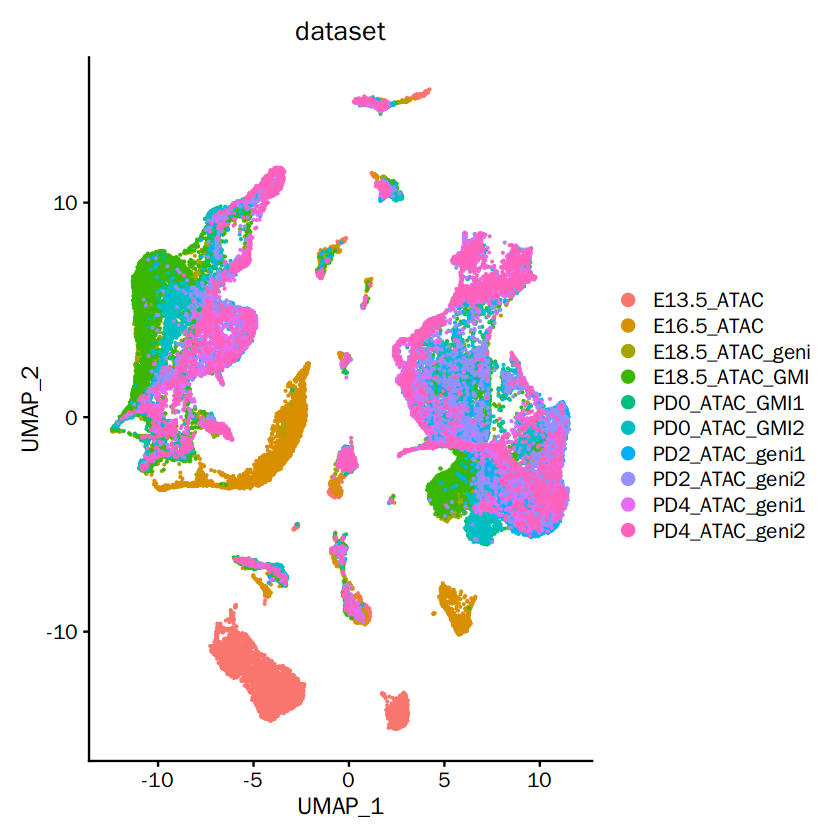

In [43]:
DimPlot(combined, group.by = 'dataset', pt.size = 0.1)

In [44]:
combined

An object of class Seurat 
338904 features across 45406 samples within 1 assay 
Active assay: peaks (338904 features, 338904 variable features)
 2 dimensional reductions calculated: lsi, umap

In [45]:
saveRDS(combined, "./RDS/E13_PD4.combined.ref.240115.rds")